# PREPARING DATASETS

In [4]:
#DEPENDENCIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score


In [1]:
#DATA SOURCES:
foreign_workers_url = 'https://statdb.mol.gov.tw/html/mon/i0120020620e.htm'
foreign_students_url = 'https://data.gov.tw/en/datasets/42158?utm_source=chatgpt.com'
unemployement_url = 'https://nstatdb.dgbas.gov.tw/dgbasall/webMain.aspx?k=engmain'

# CLEANING THE DATASETS

In [7]:
#labor Data
# Step 1: Load the CSV with headers starting at row 3 (index 2)
file_path = "A040107010-02636708.csv"  # Update with your actual path
df = pd.read_csv(file_path, header=2)

# Step 2: Rename columns to English
df.columns = ["Date_ROC", "Total_Population_Thousands", "Labor_Force_Thousands",
              "LF_Participation_Rate", "Employment_Rate", "Unemployment_Rate"]

# Step 3: Convert ROC year to Gregorian (YYYY-MM)
def convert_roc_to_ym(roc_str):
    try:
        roc_year, month = roc_str.replace("年", "-").replace("月", "").split("-")
        year = int(roc_year) + 1911
        return f"{year}-{int(month):02d}"
    except:
        return None

df["Month"] = df["Date_ROC"].apply(convert_roc_to_ym)

# Step 4: Reorder columns and clean data
df_final = df[["Month", "Total_Population_Thousands", "Labor_Force_Thousands",
               "LF_Participation_Rate", "Employment_Rate", "Unemployment_Rate"]]

df_final_filtered = df_final[(df_final["Month"] >= "2015-01") & (df_final["Month"] <= "2024-12")].reset_index(drop=True)

# Step 5: Ensure numeric columns are properly converted
df_final.iloc[:, 1:] = df_final.iloc[:, 1:].apply(pd.to_numeric, errors="coerce")

# Step 6: Drop rows where the date is missing
df_final = df_final.dropna(subset=["Month"])

# Optional: Save cleaned file
df_final.to_csv("cleaned_labor_market_data.csv", index=False)

df_final.head()


,Month,Total_Population_Thousands,Labor_Force_Thousands,LF_Participation_Rate,Employment_Rate,Unemployment_Rate
0,2013-01,23199.0,11410.0,58.42,55.99,4.16
1,2013-02,23203.0,11398.0,58.32,55.85,4.24
2,2013-03,23206.0,11396.0,58.28,55.85,4.17
3,2013-04,23208.0,11392.0,58.23,55.86,4.07
4,2013-05,23212.0,11401.0,58.25,55.89,4.06


In [14]:
import pandas as pd

# Step 1: Load your FDI liabilities CSV file
file_path = "BPP2Q01.csv"  # Replace with your actual filename
df = pd.read_csv(file_path)

# Step 2: Clean the numeric column (remove commas and convert to float)
df["直接投資-負債"] = df["直接投資-負債"].str.replace(",", "", regex=False).astype(float)

# Step 3: Map quarters to months
quarter_map = {
    "Q1": [1, 2, 3],
    "Q2": [4, 5, 6],
    "Q3": [7, 8, 9],
    "Q4": [10, 11, 12],
}

# Step 4: Expand quarterly values into monthly format
monthly_data = []
for _, row in df.iterrows():
    period = row["期間"]  # Format: "2015Q1"
    value = row["直接投資-負債"]  # in million USD
    year = int(period[:4])
    quarter = period[4:]
    for month in quarter_map.get(quarter, []):
        monthly_data.append({
            "Month": f"{year}-{month:02d}",
            "FDI_Liabilities_USD_Million": value
        })

# Step 5: Create DataFrame and filter to the target 120-month range
df_monthly = pd.DataFrame(monthly_data)
df_filtered = df_monthly[(df_monthly["Month"] >= "2015-01") & (df_monthly["Month"] <= "2024-12")].reset_index(drop=True)

# Step 6: Save the cleaned file
df_filtered.to_csv("fdi_liabilities_monthly_2015_2024.csv", index=False)

df_filtered.head()


,Month,FDI_Liabilities_USD_Million
0,2015-01,1067.0
1,2015-02,1067.0
2,2015-03,1067.0
3,2015-04,288.0
4,2015-05,288.0


In [11]:
import pandas as pd

# Step 1: Load the CSV (starting from row 3 to skip headers)
file_path = "E018101010-04552876.csv"  # Replace with your filename
df = pd.read_csv(file_path, header=2)

# Step 2: Filter out footnotes and invalid rows
df_cleaned = df[df["Period"].str.match(r"^\d{4} Q[1-4]$", na=False)].copy()

# Step 3: Define quarter-to-month mapping
q_map = {
    "Q1": [1, 2, 3],
    "Q2": [4, 5, 6],
    "Q3": [7, 8, 9],
    "Q4": [10, 11, 12],
}

# Step 4: Expand each quarter into 3 monthly entries
monthly_data = []
for _, row in df_cleaned.iterrows():
    year_str, quarter = row["Period"].split(" ")
    year = int(year_str)
    rate = row["GDP Growth Rate (%)"]
    for m in q_map[quarter]:
        monthly_data.append({
            "Month": f"{year}-{m:02d}",
            "GDP_Growth_Rate_%": rate
        })

# Step 5: Create DataFrame and filter to 2015-01 to 2024-12
df_monthly = pd.DataFrame(monthly_data)
df_monthly = df_monthly[(df_monthly["Month"] >= "2015-01") & (df_monthly["Month"] <= "2024-12")].reset_index(drop=True)

# Step 6: Save
df_monthly.to_csv("gdp_growth_monthly_2015_2024.csv", index=False)

df_monthly.head()


,Month,GDP_Growth_Rate_%
0,2015-01,4.79
1,2015-02,4.79
2,2015-03,4.79
3,2015-04,1.89
4,2015-05,1.89


In [12]:
import pandas as pd

# Step 1: Load the CSV file, skipping the initial metadata rows and handling quote characters
file_path = "E030101015-052061051.csv"  # Replace with your filename
df = pd.read_csv(file_path, skiprows=2, quotechar='"', names=["Period", "Inflation_Rate"])

# Step 2: Convert "Period" like "2015 Jan" into "YYYY-MM"
def convert_period_to_ym(period):
    try:
        parts = period.split()
        year = int(parts[0])
        month_str = parts[1]
        month_map = {
            "Jan": "01", "Feb": "02", "Mar": "03", "Apr": "04", "May": "05", "Jun": "06",
            "Jul": "07", "Aug": "08", "Sep": "09", "Oct": "10", "Nov": "11", "Dec": "12"
        }
        return f"{year}-{month_map[month_str]}"
    except:
        return None

df["Month"] = df["Period"].apply(convert_period_to_ym)

# Step 3: Reorganize and clean the dataset
df_cleaned = df[["Month", "Inflation_Rate"]].copy()
df_cleaned["Inflation_Rate"] = pd.to_numeric(df_cleaned["Inflation_Rate"], errors="coerce")

# Step 4: Filter to the date range 2015-01 to 2024-12 (120 months)
df_filtered = df_cleaned[(df_cleaned["Month"] >= "2015-01") & (df_cleaned["Month"] <= "2024-12")].reset_index(drop=True)

# Step 5: Save to CSV
df_filtered.to_csv("inflation_monthly_2015_2024.csv", index=False)

df_filtered.head()


,Month,Inflation_Rate
0,2015-01,-0.93
1,2015-02,-0.20
2,2015-03,-0.62
3,2015-04,-0.82
4,2015-05,-0.73


In [15]:
import pandas as pd

# Step 1: Load your interest rate dataset
file_path = "Monthly_Interest_Rates__2013_2025_.csv"  # Replace with your actual path
df = pd.read_csv(file_path)

# Step 2: Filter to the target 120-month period
df_filtered = df[(df["Month"] >= "2015-01") & (df["Month"] <= "2024-12")].reset_index(drop=True)

# Step 3: Save the cleaned dataset
df_filtered.to_csv("interest_rate_monthly_2015_2024.csv", index=False)

df_filtered.head()


,Month,Interest Rate (%)
0,2015-01,1.875
1,2015-02,1.875
2,2015-03,1.875
3,2015-04,1.875
4,2015-05,1.875


In [16]:
import pandas as pd
import re

# Step 1: Load the file (adjust encoding if needed)
file_path = "wq6401-211644716.csv"
df = pd.read_csv(file_path, encoding="cp950")  # for traditional Chinese CSVs

# Step 2: Convert ROC date to YYYY-MM
def convert_roc_date(date_str):
    match = re.search(r"(\d{2,3})年\s*(\d{1,2})月", date_str)
    if match:
        roc_year = int(match.group(1))
        month = int(match.group(2))
        year = roc_year + 1911
        return f"{year}-{month:02d}"
    return None

df["Month"] = df["統計期"].apply(convert_roc_date)

# Step 3: Keep only the total count and Month columns
df_cleaned = df[["Month", "總計"]].dropna()
df_cleaned.columns = ["Month", "Foreign_Workers"]

# Step 4: Convert count to numeric
df_cleaned["Foreign_Workers"] = pd.to_numeric(df_cleaned["Foreign_Workers"], errors="coerce")

# Step 5: Filter to 2015-01 to 2024-12
df_filtered = df_cleaned[(df_cleaned["Month"] >= "2015-01") & (df_cleaned["Month"] <= "2024-12")].reset_index(drop=True)

# Step 6: Save to CSV
df_filtered.to_csv("foreign_workers_monthly_2015_2024.csv", index=False)

df_filtered.head()

,Month,Foreign_Workers
0,2015-01,556412.0
1,2015-02,557774.0
2,2015-03,566518.0
3,2015-04,572555.0
4,2015-05,576584.0


# PREPROCESSING DATASETS

In [23]:
import pandas as pd

# Load finalized macroeconomic datasets
foreign_workers_df = pd.read_csv("foreign_workers_monthly_2015_2024.csv")
labor_df = pd.read_csv("cleaned_labor_market_data.csv")
fdi_df = pd.read_csv("fdi_liabilities_monthly_2015_2024.csv")
gdp_df = pd.read_csv("gdp_growth_monthly_2015_2024.csv")
inflation_df = pd.read_csv("inflation_monthly_2015_2024.csv")
interest_df = pd.read_csv("interest_rate_monthly_2015_2024.csv")

# Inspect each dataset
print("\n👷 Foreign Workers Data:")
print(foreign_workers_df.info())
print(foreign_workers_df.head())

print("\n📊 Labor Market Data:")
print(labor_df.info())
print(labor_df.head())

print("\n💰 FDI Liabilities Data (in millions USD):")
print(fdi_df.info())
print(fdi_df.head())

print("\n📈 GDP Growth Rate Data (%):")
print(gdp_df.info())
print(gdp_df.head())

print("\n💸 Inflation Rate Data (%):")
print(inflation_df.info())
print(inflation_df.head())

print("\n🏦 Interest Rate Data (%):")
print(interest_df.info())
print(interest_df.head())



👷 Foreign Workers Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Month            120 non-null    object 
 1   Foreign_Workers  120 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.0+ KB
None
     Month  Foreign_Workers
0  2015-01         556412.0
1  2015-02         557774.0
2  2015-03         566518.0
3  2015-04         572555.0
4  2015-05         576584.0

📊 Labor Market Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Month                       148 non-null    object 
 1   Total_Population_Thousands  148 non-null    float64
 2   Labor_Force_Thousands       148 non-null    float64
 3   LF_Participation_Rate       148 non-null    fl

In [20]:
import pandas as pd

# Load each cleaned dataset
df_labor = pd.read_csv("cleaned_labor_market_data.csv")
df_fdi = pd.read_csv("fdi_liabilities_monthly_2015_2024.csv")
df_gdp = pd.read_csv("gdp_growth_monthly_2015_2024.csv")
df_inflation = pd.read_csv("inflation_monthly_2015_2024.csv")
df_interest = pd.read_csv("interest_rate_monthly_2015_2024.csv")
df_foreign_workers = pd.read_csv("foreign_workers_monthly_2015_2024.csv")

# Merge on Month (inner join ensures alignment)
df_merged = df_labor.merge(df_fdi, on="Month", how="inner")
df_merged = df_merged.merge(df_gdp, on="Month", how="inner")
df_merged = df_merged.merge(df_inflation, on="Month", how="inner")
df_merged = df_merged.merge(df_interest, on="Month", how="inner")
df_merged = df_merged.merge(df_foreign_workers, on="Month", how="inner")


In [10]:
# Convert monetary to millions (FDI already in millions)
df_merged["FDI_Liabilities_USD_Millions"] = df_merged["FDI_Liabilities_USD_Million"]

# Keep population and labor force in thousands
df_merged["Total_Population_Thousands"] = df_merged["Total_Population_Thousands"]
df_merged["Labor_Force_Thousands"] = df_merged["Labor_Force_Thousands"]
df_merged["Foreign_Workers_Thousands"] = df_merged["Foreign_Workers"] / 1_000

# Convert ratios to percentages
df_merged["Unemployment_Rate_Percent"] = df_merged["Unemployment_Rate"]
df_merged["Employment_Rate_Percent"] = df_merged["Employment_Rate"]
df_merged["LF_Participation_Rate_Percent"] = df_merged["LF_Participation_Rate"]
df_merged["Foreign_Worker_Ratio_Percent"] = (df_merged["Foreign_Workers"] / (df_merged["Labor_Force_Thousands"] * 1_000)) * 100

# Select final columns
df_final = df_merged[[
    "Month",
    "Total_Population_Thousands",
    "Labor_Force_Thousands",
    "Foreign_Workers_Thousands",
    "Unemployment_Rate_Percent",
    "Employment_Rate_Percent",
    "LF_Participation_Rate_Percent",
    "Foreign_Worker_Ratio_Percent",
    "FDI_Liabilities_USD_Millions",
    "GDP_Growth_Rate_%",
    "Inflation_Rate",
    "Interest Rate (%)"
]]

# Save merged and standardized dataset
df_final.to_csv("final_macro_dataset_standardized_units.csv", index=False)

print("✅ All datasets merged and standardized. File saved as 'final_macro_dataset_standardized_units.csv'")


NameError: name 'df_merged' is not defined

# DATA VISUALIZATION AND ANALYSIS

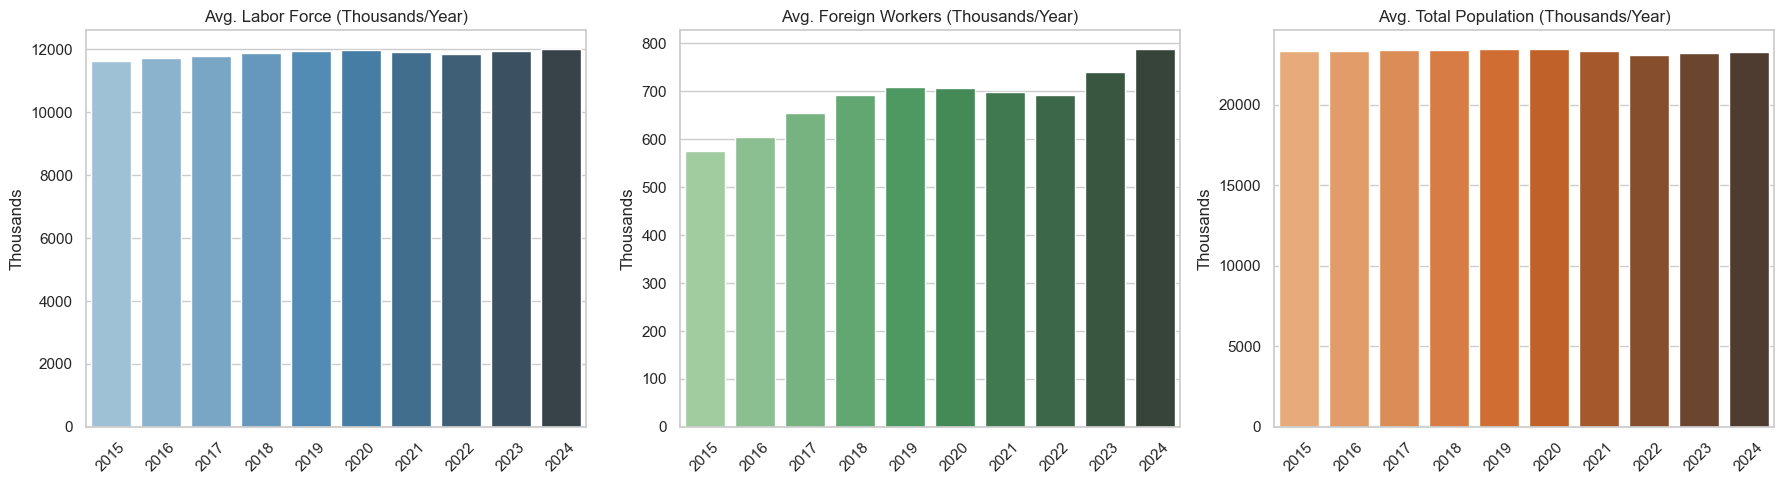

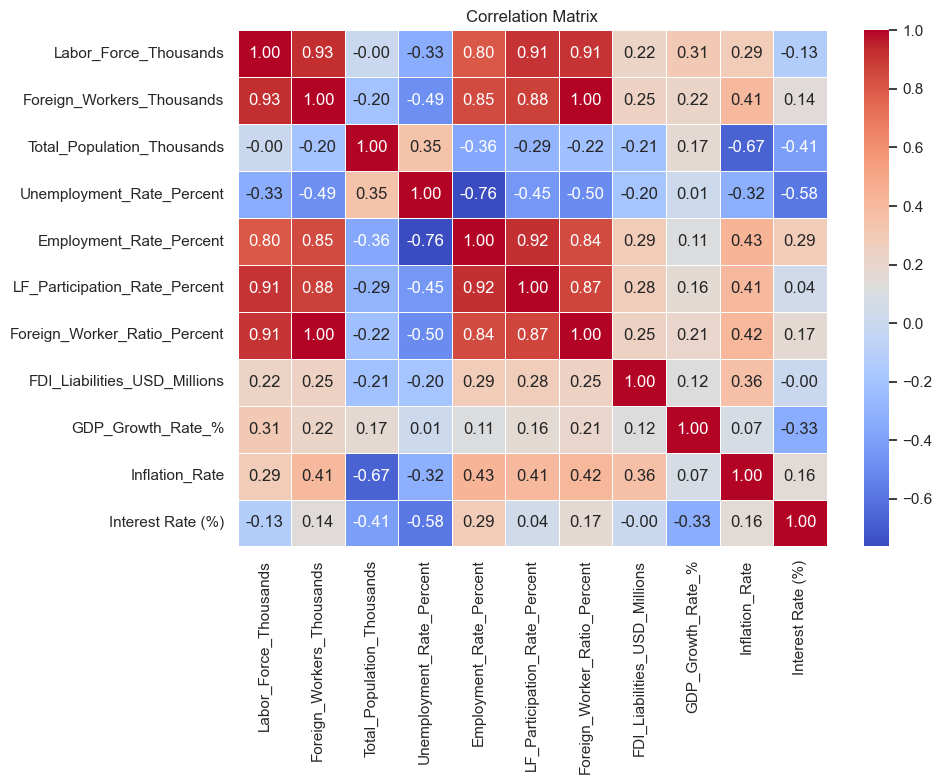

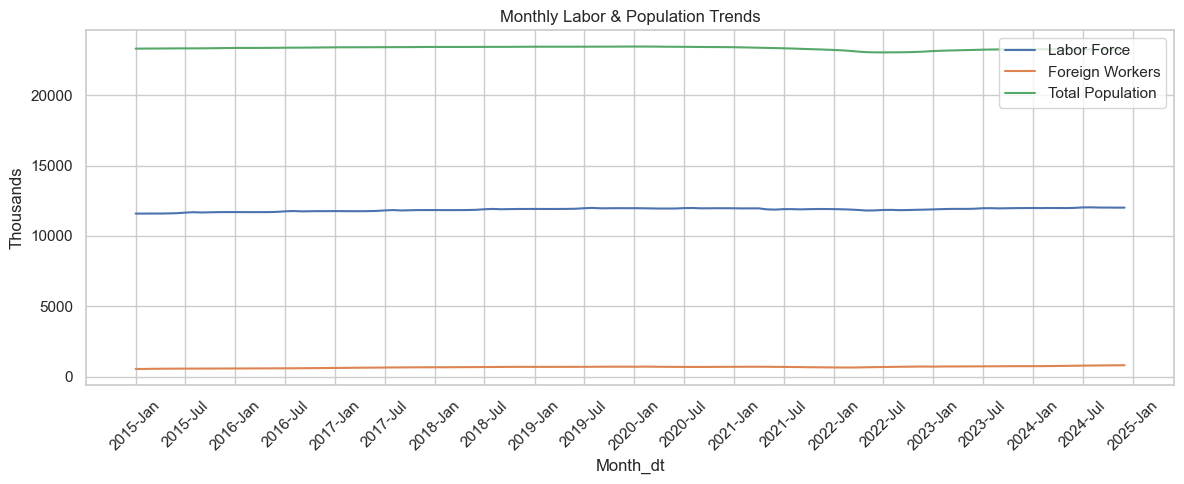

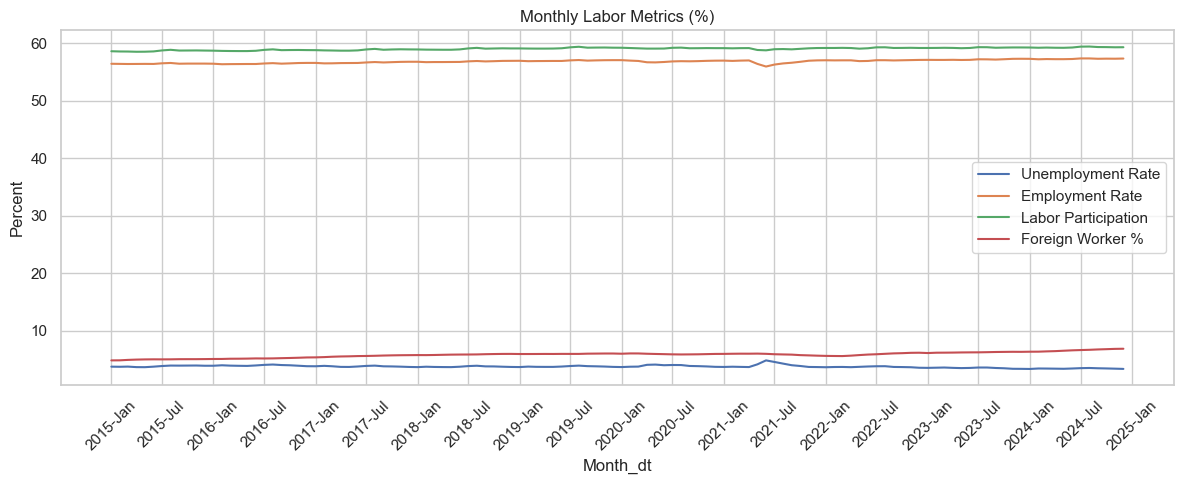

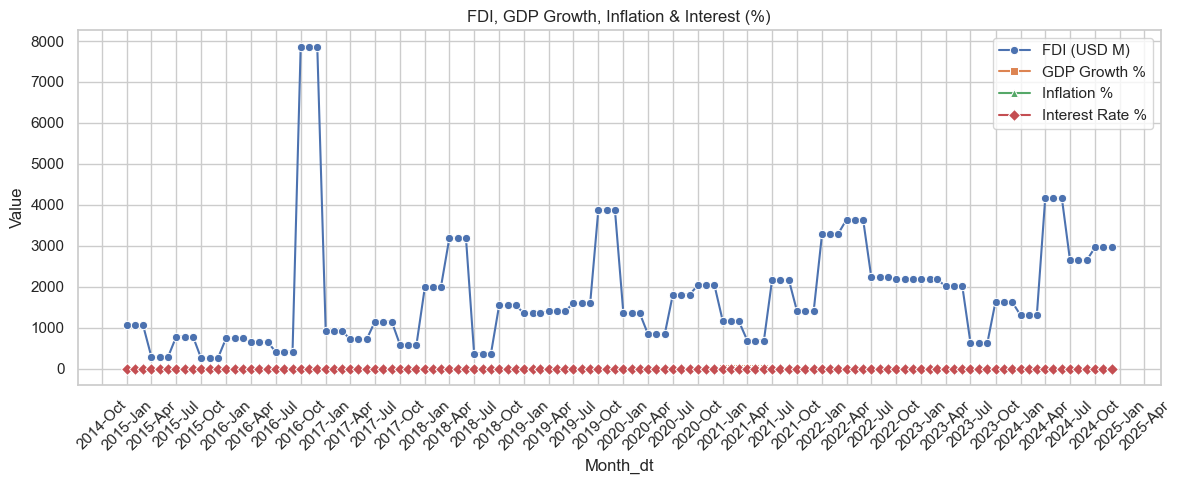

C:\Users\Enzo Fabien\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


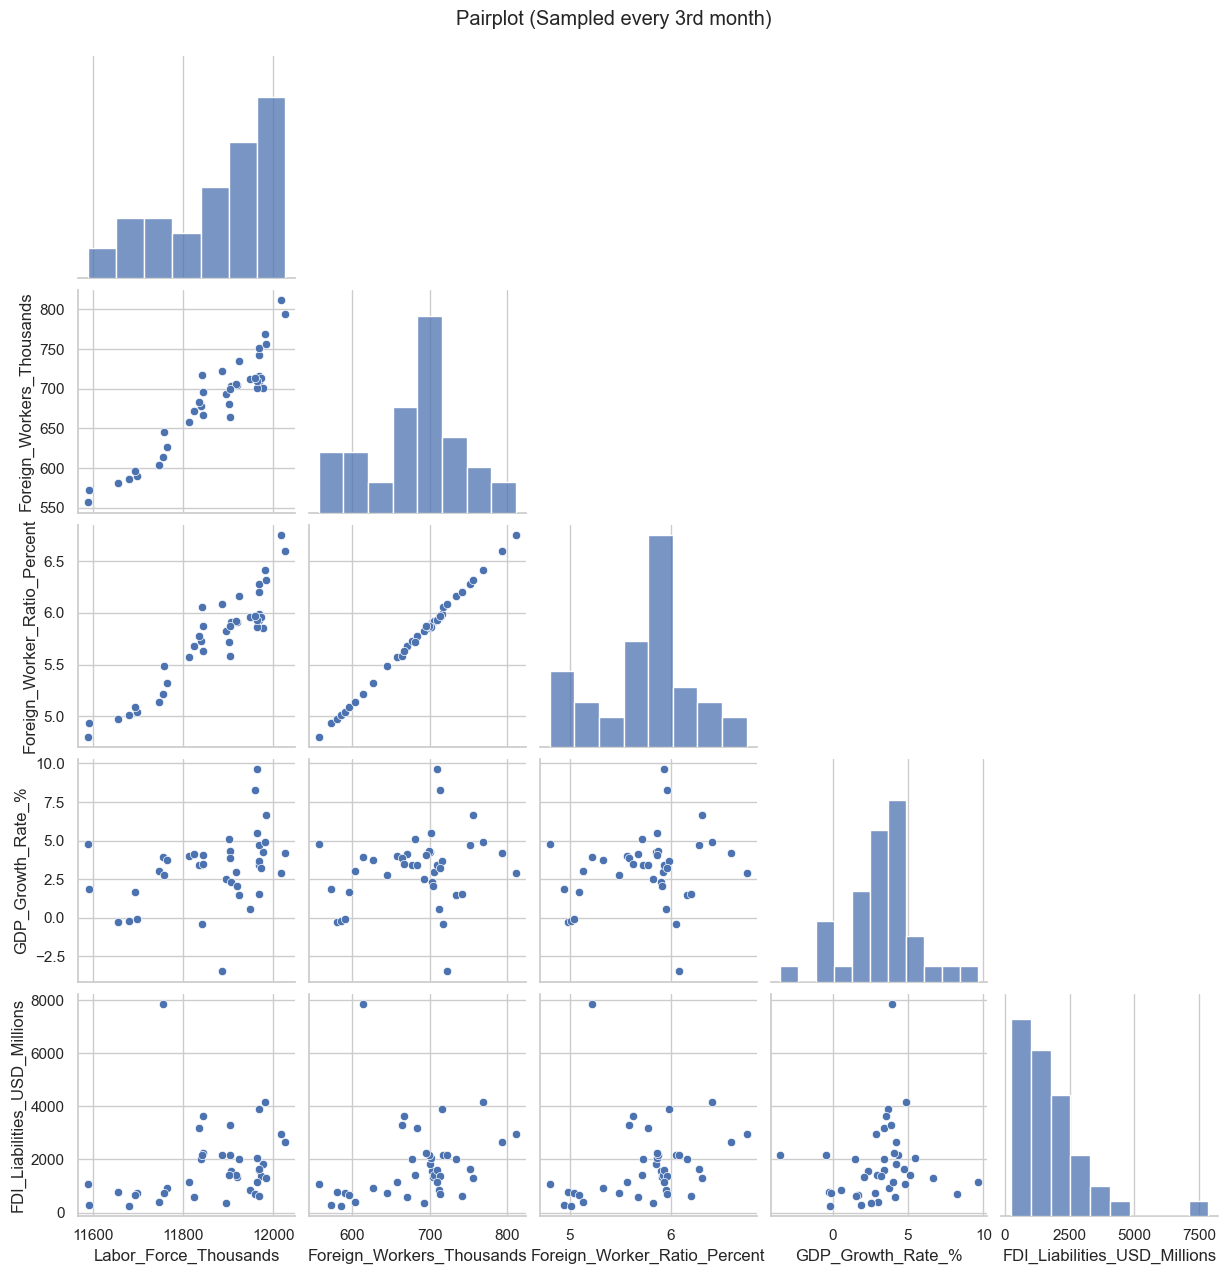

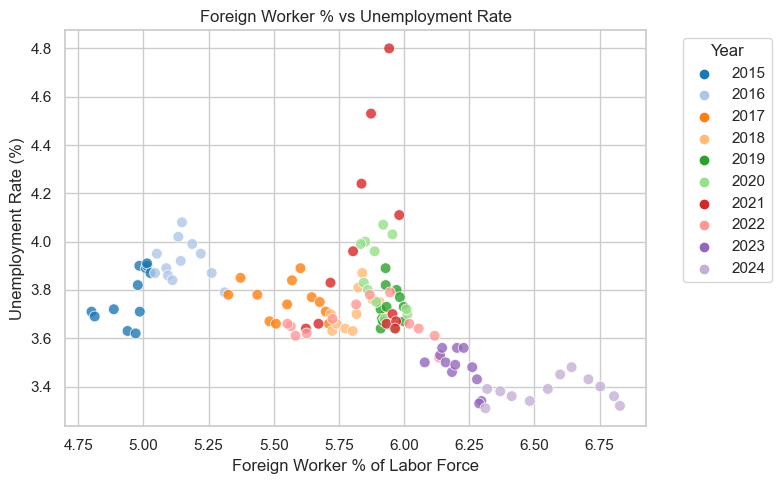

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

sns.set(style="whitegrid")

# 0. Prepare the DataFrame
df = df_final.copy()
df['Month_dt'] = pd.to_datetime(df['Month'])
df['Year']     = df['Month_dt'].dt.year
df['Quarter']  = df['Month_dt'].dt.to_period('Q').dt.strftime('Q%q')

# ─── 1. BAR PLOTS – Yearly Aggregates for Unit‐Based Variables ────────────────
yearly = df.groupby('Year').agg({
    'Labor_Force_Thousands': 'mean',
    'Foreign_Workers_Thousands': 'mean',
    'Total_Population_Thousands': 'mean'
}).reset_index()

fig, axes = plt.subplots(1, 3, figsize=(18,5))
pal = sns.color_palette("Blues_d", len(yearly))

sns.barplot(x='Year', y='Labor_Force_Thousands', data=yearly, ax=axes[0], palette=pal)
axes[0].set_title('Avg. Labor Force (Thousands/Year)')
axes[0].set_ylabel('Thousands')

sns.barplot(x='Year', y='Foreign_Workers_Thousands', data=yearly, ax=axes[1], palette="Greens_d")
axes[1].set_title('Avg. Foreign Workers (Thousands/Year)')
axes[1].set_ylabel('Thousands')

sns.barplot(x='Year', y='Total_Population_Thousands', data=yearly, ax=axes[2], palette="Oranges_d")
axes[2].set_title('Avg. Total Population (Thousands/Year)')
axes[2].set_ylabel('Thousands')

for ax in axes:
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# ─── 2. CORRELATION HEATMAP ─────────────────────────────────────────────────────
plt.figure(figsize=(10,8))
corr_vars = [
    'Labor_Force_Thousands','Foreign_Workers_Thousands','Total_Population_Thousands',
    'Unemployment_Rate_Percent','Employment_Rate_Percent','LF_Participation_Rate_Percent',
    'Foreign_Worker_Ratio_Percent','FDI_Liabilities_USD_Millions','GDP_Growth_Rate_%',
    'Inflation_Rate','Interest Rate (%)'
]
sns.heatmap(df[corr_vars].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# ─── 3. LINE PLOTS ─────────────────────────────────────────────────────────────

# A) Units (monthly)
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(x='Month_dt', y='Labor_Force_Thousands', data=df, label='Labor Force', ax=ax)
sns.lineplot(x='Month_dt', y='Foreign_Workers_Thousands', data=df, label='Foreign Workers', ax=ax)
sns.lineplot(x='Month_dt', y='Total_Population_Thousands', data=df, label='Total Population', ax=ax)
ax.set_title("Monthly Labor & Population Trends")
ax.set_ylabel("Thousands")
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1,7)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# B) Rates (monthly)
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(x='Month_dt', y='Unemployment_Rate_Percent', data=df, label='Unemployment Rate', ax=ax)
sns.lineplot(x='Month_dt', y='Employment_Rate_Percent', data=df, label='Employment Rate', ax=ax)
sns.lineplot(x='Month_dt', y='LF_Participation_Rate_Percent', data=df, label='Labor Participation', ax=ax)
sns.lineplot(x='Month_dt', y='Foreign_Worker_Ratio_Percent', data=df, label='Foreign Worker %', ax=ax)
ax.set_title("Monthly Labor Metrics (%)")
ax.set_ylabel("Percent")
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1,7)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# C) Money & Macro Rates (quarterly-style spacing)
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(x='Month_dt', y='FDI_Liabilities_USD_Millions', data=df, marker='o', label='FDI (USD M)', ax=ax)
sns.lineplot(x='Month_dt', y='GDP_Growth_Rate_%', data=df, marker='s', label='GDP Growth %', ax=ax)
sns.lineplot(x='Month_dt', y='Inflation_Rate', data=df, marker='^', label='Inflation %', ax=ax)
sns.lineplot(x='Month_dt', y='Interest Rate (%)', data=df, marker='D', label='Interest Rate %', ax=ax)
ax.set_title("FDI, GDP Growth, Inflation & Interest (%)")
ax.set_ylabel("Value")
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1,4,7,10)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax.tick_params(axis='x', rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# ─── 4. PAIRPLOT (sampled for readability) ────────────────────────────────────
# sample every 3rd month to reduce overplotting
sampled = df.iloc[::3]
sns.pairplot(
    sampled,
    vars=[
      'Labor_Force_Thousands','Foreign_Workers_Thousands','Foreign_Worker_Ratio_Percent',
      'GDP_Growth_Rate_%','FDI_Liabilities_USD_Millions'
    ],
    diag_kind='hist',
    corner=True
)
plt.suptitle("Pairplot (Sampled every 3rd month)", y=1.02)
plt.show()

# ─── 5. SCATTERPLOT: Worker % vs Unemployment ────────────────────────────────
plt.figure(figsize=(8,5))
sns.scatterplot(
    x='Foreign_Worker_Ratio_Percent',
    y='Unemployment_Rate_Percent',
    hue='Year',
    palette='tab20',
    data=df,
    s=60,
    alpha=0.8
)
plt.title("Foreign Worker % vs Unemployment Rate")
plt.xlabel("Foreign Worker % of Labor Force")
plt.ylabel("Unemployment Rate (%)")
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# MULTIVARIATE ANALYSIS

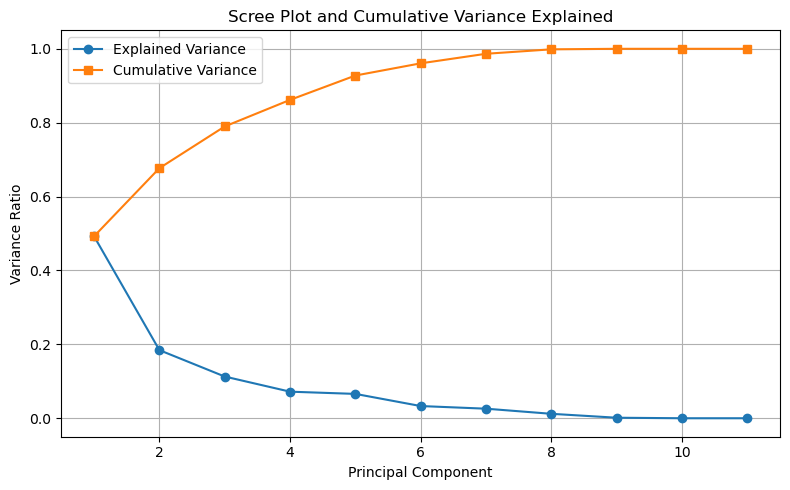

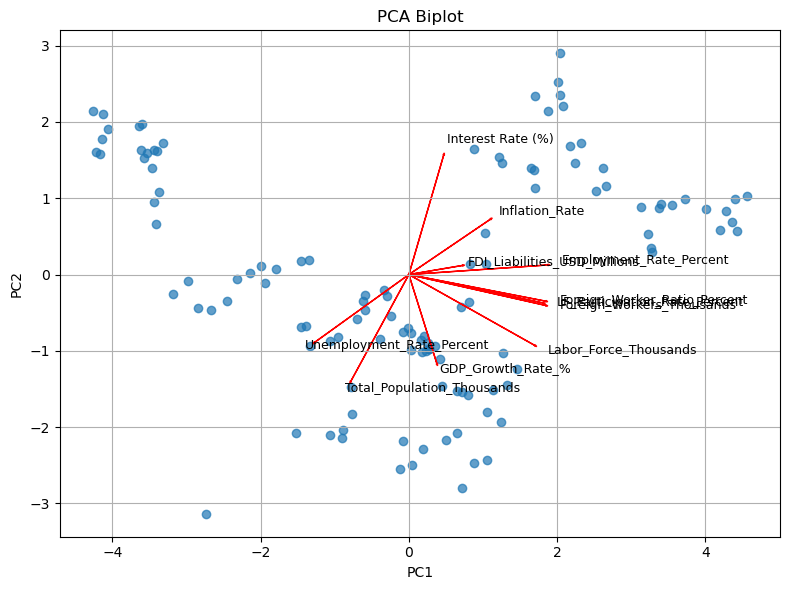

   Principal Component  Explained Variance  Cumulative Variance
0                  PC1        4.925285e-01             0.492529
1                  PC2        1.843794e-01             0.676908
2                  PC3        1.129059e-01             0.789814
3                  PC4        7.192498e-02             0.861739
4                  PC5        6.591030e-02             0.927649
5                  PC6        3.303221e-02             0.960681
6                  PC7        2.587333e-02             0.986555
7                  PC8        1.202286e-02             0.998577
8                  PC9        1.413270e-03             0.999991
9                 PC10        8.316046e-06             0.999999
10                PC11        9.524391e-07             1.000000
Silhouette Score:           0.369
Calinski–Harabasz Index:    72.7
Davies–Bouldin Index:       1.075


C:\Users\Enzo Fabien\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [9]:

# MULTIVARIATE ANALYSIS (UPDATED WITH PRUNED VARIABLES)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cross_decomposition import CCA
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Selected final variables (non-redundant)
selected_vars = [
    'Unemployment_Rate_Percent',
    'LF_Participation_Rate_Percent',
    'Foreign_Worker_Ratio_Percent',
    'GDP_Growth_Rate_%',
    'Inflation_Rate',
    'Interest Rate (%)',
    'FDI_Liabilities_USD_Millions'
]

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_final[selected_vars])

# PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', label='Explained')
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='s', label='Cumulative')
plt.xlabel('Principal Component')
plt.ylabel('Variance Ratio')
plt.title('PCA Scree Plot')
plt.legend()
plt.tight_layout()
plt.show()

# Factor Analysis
fa = FactorAnalysis(n_components=3, random_state=0)
fa_fit = fa.fit(X_scaled)
fa_df = pd.DataFrame(fa.components_.T, index=selected_vars, columns=['Factor1', 'Factor2', 'Factor3'])

# Plot factor loadings
fa_df.plot(kind='barh', figsize=(10, 6))
plt.title("Factor Loadings (3 Factors)")
plt.tight_layout()
plt.show()

# Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)

print("Silhouette Score:", silhouette_score(X_scaled, labels))
print("Calinski–Harabasz Index:", calinski_harabasz_score(X_scaled, labels))
print("Davies–Bouldin Index:", davies_bouldin_score(X_scaled, labels))

# LDA
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X_scaled, labels)
y_pred = lda.predict(X_scaled)
acc = accuracy_score(labels, y_pred)
print(f"LDA accuracy: {acc:.2f}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_lda[:, 0], y=X_lda[:, 1], hue=labels, palette='tab10')
plt.title('LDA Projection of Clusters')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.tight_layout()
plt.show()

# CCA
labor_block = df_final[['Unemployment_Rate_Percent', 'LF_Participation_Rate_Percent', 'Foreign_Worker_Ratio_Percent']]
macro_block = df_final[['GDP_Growth_Rate_%', 'Inflation_Rate', 'Interest Rate (%)', 'FDI_Liabilities_USD_Millions']]

scaler_l = StandardScaler()
scaler_m = StandardScaler()
X_labor = scaler_l.fit_transform(labor_block)
X_macro = scaler_m.fit_transform(macro_block)

cca = CCA(n_components=2)
U, V = cca.fit_transform(X_labor, X_macro)
print("CCA Canonical Correlation 1:", pd.Series(U[:, 0]).corr(pd.Series(V[:, 0])))
print("CCA Canonical Correlation 2:", pd.Series(U[:, 1]).corr(pd.Series(V[:, 1])))

plt.figure(figsize=(8, 6))
sns.scatterplot(x=U[:, 0], y=V[:, 0])
plt.title("CCA Canonical Correlation: Labor vs Macro (U1 vs V1)")
plt.xlabel("Labor Component (U1)")
plt.ylabel("Macro Component (V1)")
plt.tight_layout()
plt.show()


                                Factor1   Factor2   Factor3
Total_Population_Thousands     0.056374  0.784977 -0.586349
Labor_Force_Thousands         -0.995255  0.080715  0.013625
Foreign_Workers_Thousands     -0.943054 -0.160862  0.036328
Unemployment_Rate_Percent      0.399284  0.765825  0.471122
Employment_Rate_Percent       -0.847921 -0.483935 -0.109993
LF_Participation_Rate_Percent -0.930017 -0.202583  0.134800
Foreign_Worker_Ratio_Percent  -0.929346 -0.184073  0.041379
FDI_Liabilities_USD_Millions  -0.239211 -0.187596  0.099007
GDP_Growth_Rate_%             -0.287898  0.224421 -0.037161
Inflation_Rate                -0.322910 -0.490981  0.436167
Interest Rate (%)              0.063577 -0.678773 -0.196017


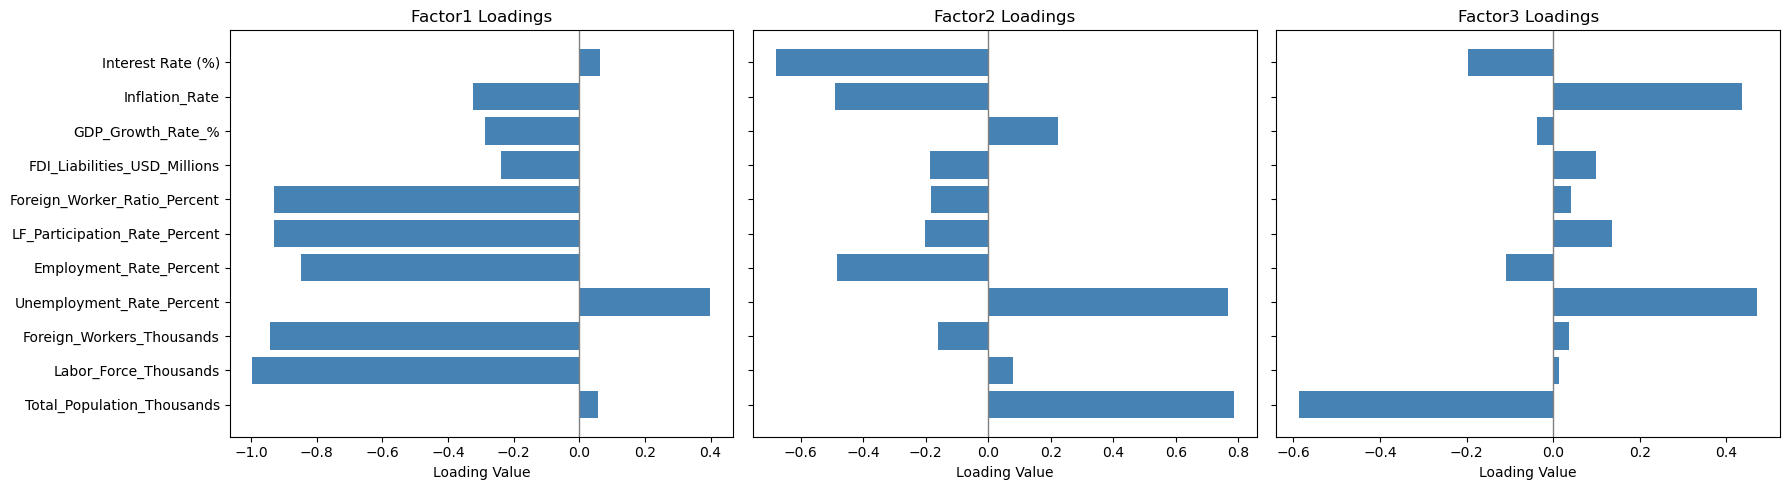

In [3]:
import pandas as pd
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler

# Load the standardized dataset
df = pd.read_csv('final_macro_dataset_standardized_units.csv')

# Prepare numeric features
numeric_df = df.drop(columns=['Month'])
features = numeric_df.columns.tolist()

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_df)

# Run Factor Analysis with 3 factors
fa = FactorAnalysis(n_components=3, random_state=0)
fa.fit(X_scaled)

# Extract loadings
loadings = fa.components_.T
fa_df = pd.DataFrame(loadings, index=features, columns=['Factor1', 'Factor2', 'Factor3'])

# Display loadings
print(fa_df)

import matplotlib.pyplot as plt

# Bar plot of factor loadings per factor
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, col in enumerate(fa_df.columns):
    axes[i].barh(fa_df.index, fa_df[col], color='steelblue')
    axes[i].set_title(f'{col} Loadings')
    axes[i].axvline(0, color='gray', lw=1)
    axes[i].set_xlabel('Loading Value')

plt.tight_layout()
plt.show()


C:\Users\Enzo Fabien\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Enzo Fabien\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Enzo Fabien\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Enzo Fabien\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have

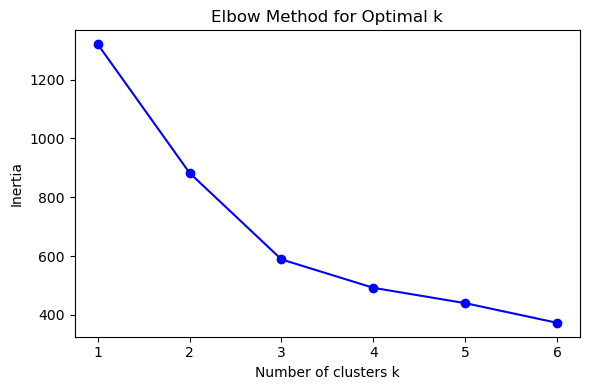

C:\Users\Enzo Fabien\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


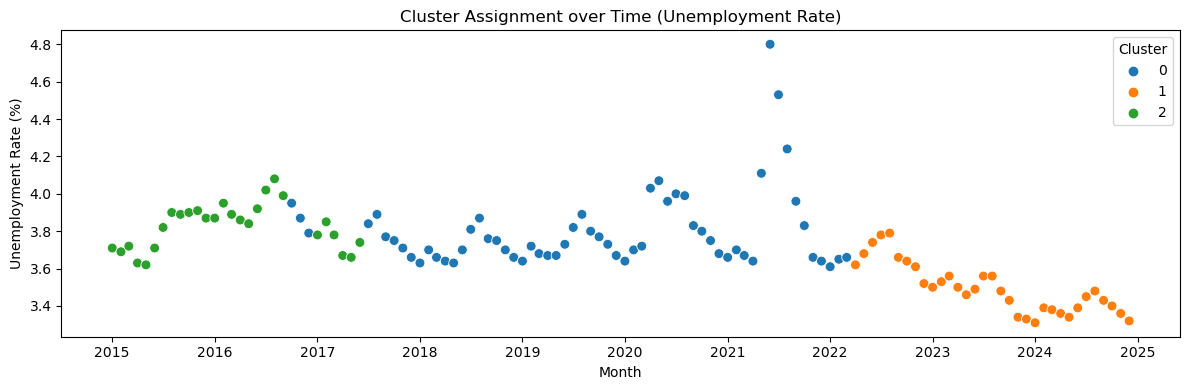

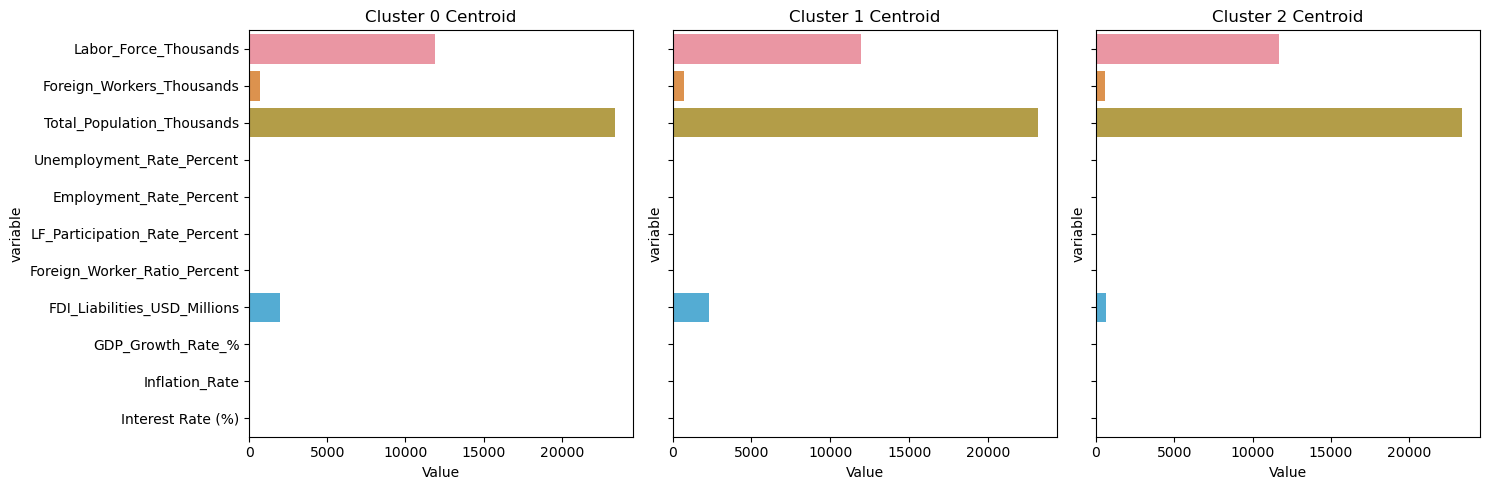

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load data
df = pd.read_csv('final_macro_dataset_standardized_units.csv')
df['Month_dt'] = pd.to_datetime(df['Month'])

# Numeric features
numeric_cols = [
    'Labor_Force_Thousands', 'Foreign_Workers_Thousands', 'Total_Population_Thousands',
    'Unemployment_Rate_Percent', 'Employment_Rate_Percent', 'LF_Participation_Rate_Percent',
    'Foreign_Worker_Ratio_Percent', 'FDI_Liabilities_USD_Millions',
    'GDP_Growth_Rate_%', 'Inflation_Rate', 'Interest Rate (%)'
]
X = df[numeric_cols]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow method to find optimal k
inertia = []
for k in range(1, 7):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)
plt.figure(figsize=(6,4))
plt.plot(range(1, 7), inertia, 'bo-')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.tight_layout()
plt.show()

# K-Means with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Plot cluster assignment over time
plt.figure(figsize=(12,4))
sns.scatterplot(x='Month_dt', y='Unemployment_Rate_Percent', hue='Cluster',
                palette='tab10', data=df, s=50)
plt.title('Cluster Assignment over Time (Unemployment Rate)')
plt.ylabel('Unemployment Rate (%)')
plt.xlabel('Month')
plt.legend(title='Cluster', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

# Centroids bar plots
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
cent_df = pd.DataFrame(centroids, columns=numeric_cols)
cent_df['Cluster'] = cent_df.index

fig, axes = plt.subplots(1, 3, figsize=(15,5), sharey=True)
for i, ax in enumerate(axes):
    data = pd.melt(cent_df[cent_df['Cluster']==i], id_vars=['Cluster'])
    sns.barplot(x='value', y='variable', data=data, ax=ax)
    ax.set_title(f'Cluster {i} Centroid')
    ax.set_xlabel('Value')
plt.tight_layout()
plt.show()


C:\Users\Enzo Fabien\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


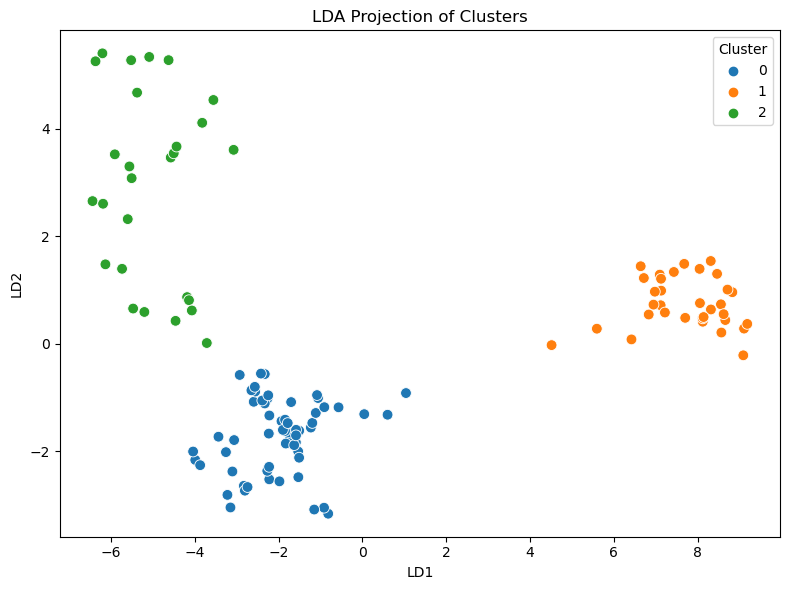

LDA classification accuracy on training data: 0.99


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Load merged dataset
df = pd.read_csv('final_macro_dataset_standardized_units.csv')

# Define numeric features
numeric_cols = [
    'Labor_Force_Thousands', 'Foreign_Workers_Thousands', 'Total_Population_Thousands',
    'Unemployment_Rate_Percent', 'Employment_Rate_Percent', 'LF_Participation_Rate_Percent',
    'Foreign_Worker_Ratio_Percent', 'FDI_Liabilities_USD_Millions',
    'GDP_Growth_Rate_%', 'Inflation_Rate', 'Interest Rate (%)'
]
X = df[numeric_cols].values

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Recompute clusters (k=3)
kmeans = KMeans(n_clusters=3, random_state=42)
y = kmeans.fit_predict(X_scaled)

# Perform LDA
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X_scaled, y)

# Plot LDA projection
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_lda[:, 0], y=X_lda[:, 1], hue=y, palette='tab10', s=60)
plt.title('LDA Projection of Clusters')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(title='Cluster', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

from sklearn.metrics import accuracy_score

# Predict cluster labels using the trained LDA model
y_pred = lda.predict(X_scaled)

# Compute accuracy
accuracy = accuracy_score(y, y_pred)
print(f"LDA classification accuracy on training data: {accuracy:.2f}")


Canonical Correlation 1: 0.681
Canonical Correlation 2: 0.429

X Loadings (Labor block):
                                    CC1       CC2
Unemployment_Rate_Percent      0.762658  0.017713
LF_Participation_Rate_Percent  0.476164  0.661153
Foreign_Worker_Ratio_Percent  -0.437745  0.750042

Y Loadings (Macro block):
                                   CC1       CC2
GDP_Growth_Rate_%            -0.288332  0.339380
Inflation_Rate               -0.194107  0.848835
Interest Rate (%)            -0.930244 -0.314623
FDI_Liabilities_USD_Millions -0.117612  0.255564


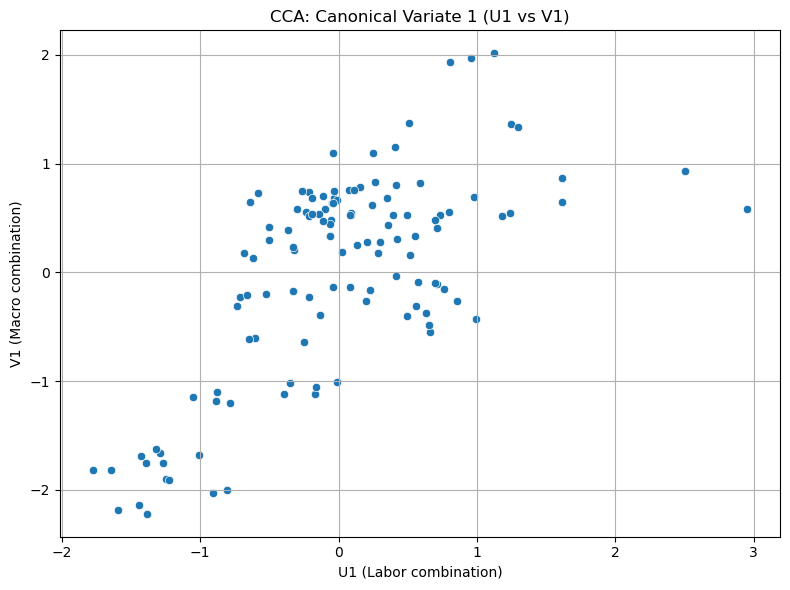

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv('final_macro_dataset_standardized_units.csv')

# Define two variable blocks
blockA = ['Unemployment_Rate_Percent', 'LF_Participation_Rate_Percent', 'Foreign_Worker_Ratio_Percent']
blockB = ['GDP_Growth_Rate_%', 'Inflation_Rate', 'Interest Rate (%)', 'FDI_Liabilities_USD_Millions']

# Standardize each block separately
X = df[blockA]
Y = df[blockB]
scalerX = StandardScaler()
scalerY = StandardScaler()
X_std = scalerX.fit_transform(X)
Y_std = scalerY.fit_transform(Y)

# Run CCA with 2 canonical components
cca = CCA(n_components=2)
U, V = cca.fit_transform(X_std, Y_std)

# Compute canonical correlations
corr1 = pd.Series(U[:, 0]).corr(pd.Series(V[:, 0]))
corr2 = pd.Series(U[:, 1]).corr(pd.Series(V[:, 1]))

print(f'Canonical Correlation 1: {corr1:.3f}')
print(f'Canonical Correlation 2: {corr2:.3f}')

# Show canonical loadings (weights)
x_loadings = pd.DataFrame(cca.x_weights_, index=blockA, columns=['CC1', 'CC2'])
y_loadings = pd.DataFrame(cca.y_weights_, index=blockB, columns=['CC1', 'CC2'])

print("\nX Loadings (Labor block):")
print(x_loadings)

print("\nY Loadings (Macro block):")
print(y_loadings)

# Scatterplot of canonical variates
plt.figure(figsize=(8, 6))
sns.scatterplot(x=U[:, 0], y=V[:, 0])
plt.title('CCA: Canonical Variate 1 (U1 vs V1)')
plt.xlabel('U1 (Labor combination)')
plt.ylabel('V1 (Macro combination)')
plt.grid(True)
plt.tight_layout()
plt.show()
